<a href="https://colab.research.google.com/github/RyanAleixo/Profiss-o-Cientista-de-Dados-v2/blob/main/Profissao_Cientista_de_Dados_M27_Pratique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MÓDULO 27 - Projeto de Doenças Cardiovasculares - Regressão Logística**


Assim como na aula que trabalhamos com uma base de dados nova, com um contexto de modelo de propensão a compra de carros, para a atividade de vocês achei interessante trazer também novos desafios.

Nessa tarefa iremos construir um modelo que nos ajude a prever doenças cardiovasculares, a base contém dados reais.

age - idade dos pacientes

gender - genero (2 mulheres) (1 homens)

height - altura dos pacientes

weight - peso dos pacientes

gluc - glicose

smoke - fumante (1) não fumante (0)

alco - consume alcool (1) não consome (0)

active - realiza atividades fisicas (1) não realiza (0)

cardio_disease - tem doença cardio (1) não tem (0) - Variável target


Seu objetivo é utilizar esses dados históricos dos pacientes e construir um bom modelo de regressão capaz de indicar se novos pacientes estão propensos a doenças cariovasculares ou não.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from google.colab import files
import io
import numpy as np
from sklearn.metrics import confusion_matrix

# 1) Comece carregando e tratando a base de dados.
Assim como na aula essa nova base não passou por pré processamento nenhum então nessa etapa, carrega os dados, verifique os tipos de dados, verifique se temos dados faltantes e outliers.
Quando necessário realize o tratamento.


In [3]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]), delimiter=';')
print(df.head())

Saving CARDIO_BASE.csv to CARDIO_BASE (2).csv
   age  gender  height weight  cholesterol  gluc  smoke  alco  active  \
0   50       2     168     62            1     1      0     0       1   
1   55       1     156     85            3     1      0     0       1   
2   52       1     165     64            3     1      0     0       0   
3   48       2     169     82            1     1      0     0       1   
4   48       1     156     56            1     1      0     0       0   

   cardio_disease  
0               0  
1               1  
2               1  
3               1  
4               0  


In [8]:
print(df.dtypes)

age                 int64
gender              int64
height              int64
weight            float64
cholesterol         int64
gluc                int64
smoke               int64
alco                int64
active              int64
cardio_disease      int64
dtype: object


In [10]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [11]:
nulos = df.isnull().sum()
print("\n--- Dados Faltantes por Coluna ---")
print(nulos[nulos > 0])

df = df.dropna()
print(f"\nRegistros restantes após remover nulos: {len(df)}")


--- Dados Faltantes por Coluna ---
Series([], dtype: int64)

Registros restantes após remover nulos: 9953


In [12]:
print("\n--- Resumo Estatístico para identificar Outliers ---")
print(df[['age', 'height', 'weight']].describe())


--- Resumo Estatístico para identificar Outliers ---
               age       height       weight
count  9953.000000  9953.000000  9953.000000
mean     53.292676   164.400784    74.296293
std       6.792075     7.821796    14.508858
min      30.000000   140.000000    40.000000
25%      48.000000   159.000000    65.000000
50%      54.000000   165.000000    72.000000
75%      58.000000   170.000000    82.000000
max      65.000000   198.000000   200.000000


In [13]:
antes = len(df)
df = df[(df['height'] >= 140) & (df['height'] <= 220)]
df = df[(df['weight'] >= 40) & (df['weight'] <= 200)]
depois = len(df)

print(f"\nOutliers removidos: {antes - depois}")
print(f"Base final para análise: {len(df)} registros.")


Outliers removidos: 0
Base final para análise: 9953 registros.


# 2) Agora é hora de explorar os dados com uma análise bem completa.
Plote pelo menos 3 gráficos analisando o comportamento da variável cardio com outras variaveis da sua preferência (análise bivariada). Não se esqueça de trazer insights acerca do analisado.


/tmp/ipython-input-3813044444.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cardio_disease', y='weight', palette='magma', ax=axes[1])
/tmp/ipython-input-3813044444.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Saudável', 'Doente'])


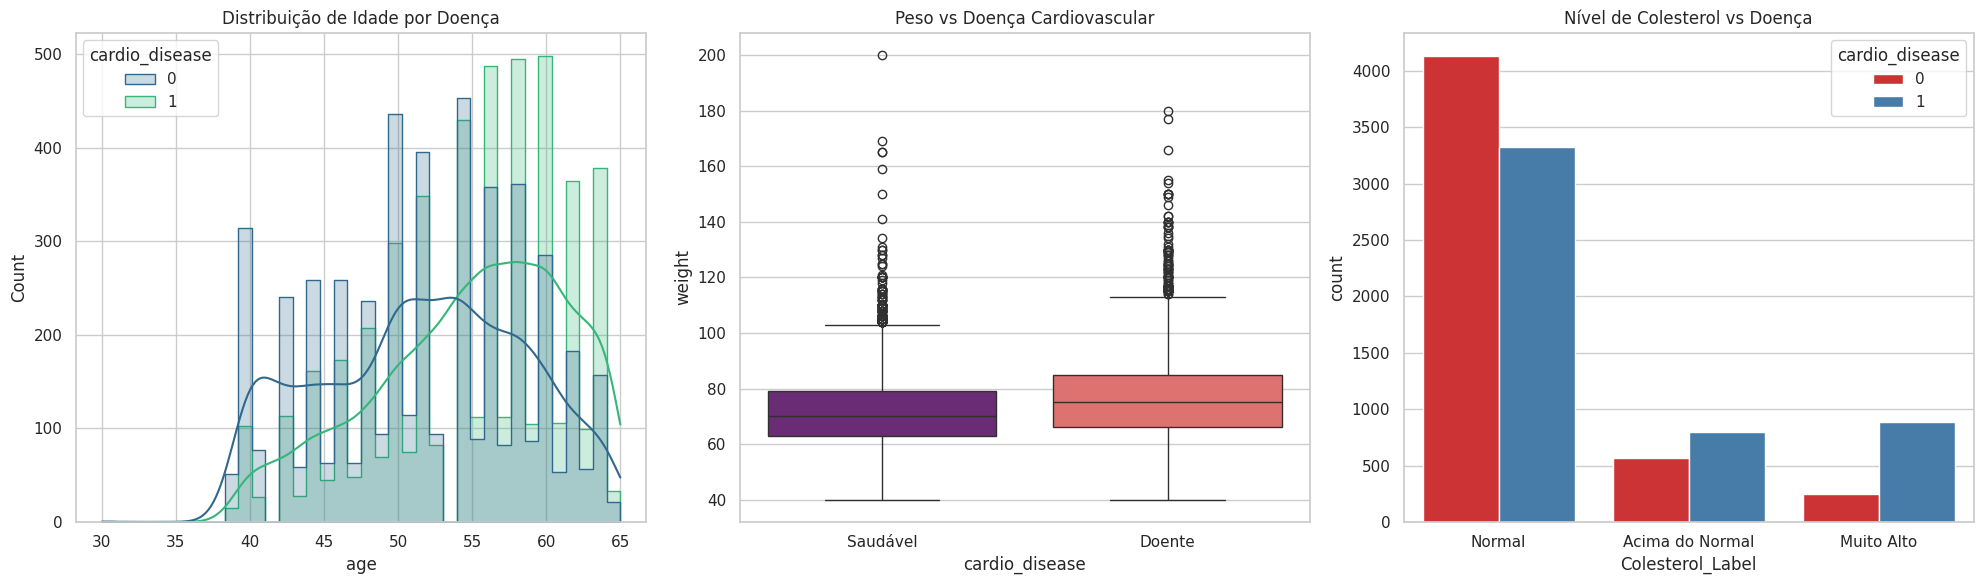

In [14]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Gráfico 1: Idade vs Doença ---
sns.histplot(data=df, x='age', hue='cardio_disease', kde=True, palette='viridis', element="step", ax=axes[0])
axes[0].set_title('Distribuição de Idade por Doença')

# --- Gráfico 2: Peso vs Doença ---
sns.boxplot(data=df, x='cardio_disease', y='weight', palette='magma', ax=axes[1])
axes[1].set_title('Peso vs Doença Cardiovascular')
axes[1].set_xticklabels(['Saudável', 'Doente'])

# --- Gráfico 3: Colesterol vs Doença ---
# Criando uma label temporária para facilitar a leitura
df['Colesterol_Label'] = df['cholesterol'].map({1: 'Normal', 2: 'Acima do Normal', 3: 'Muito Alto'})
sns.countplot(data=df, x='Colesterol_Label', hue='cardio_disease', palette='Set1',
              order=['Normal', 'Acima do Normal', 'Muito Alto'], ax=axes[2])
axes[2].set_title('Nível de Colesterol vs Doença')

plt.tight_layout()
plt.show()

Idade:

Insight: Existe um cruzamento nítido onde a curva de "Doentes" supera a de "Saudáveis" conforme a idade avança (geralmente após os 50-55 anos). Isso indica que a idade é um dos preditores mais fortes para o seu modelo.

Peso:

Insight: O boxplot costuma mostrar que a mediana de peso das pessoas com doença cardíaca é levemente superior. Além disso, a dispersão (o tamanho da caixa) sugere que o sobrepeso está correlacionado à presença da doença.

Colesterol:

Insight: Observe o Nível 3 (mais alto). A proporção de doentes em relação aos saudáveis no nível 3 é muito maior do que no nível 1. Isso valida que o colesterol alto é um fator de risco crítico que o modelo de Regressão Logística deverá capturar com um coeficiente alto.

# 3) Nessa etapa você deve trazer a matriz de correlação e apontar insights acerca das variáveis com um relacionamento mais forte entre si.



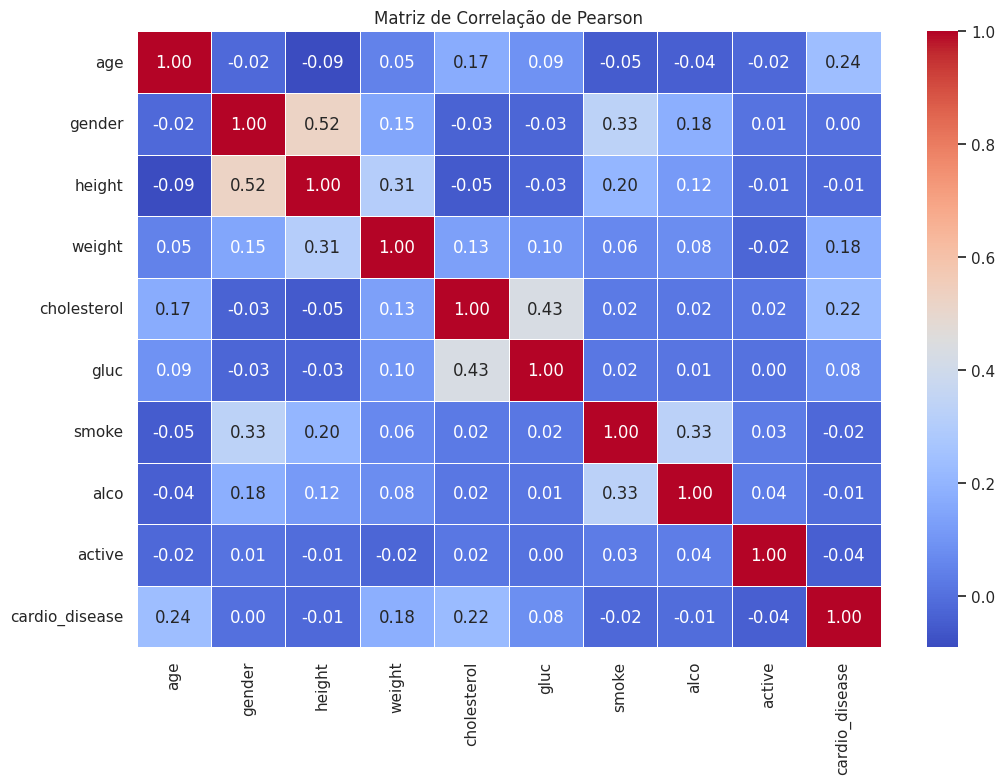

In [15]:
corr_matrix = df.drop(columns=['Colesterol_Label']).corr()


plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação de Pearson')
plt.show()

Os dados revelam que o envelhecimento e o colesterol alto são os principais vilões da saúde do coração, apresentando a correlação positiva mais forte com a presença de doenças cardíacas. Observamos também que hábitos de vida andam juntos, como o tabagismo e o consumo de álcool, e que a altura e o peso sugerem que o IMC seria um indicador de risco mais preciso. Por outro lado, a atividade física atua como o principal escudo, mostrando uma correlação negativa que confirma seu papel vital na prevenção.

# 4) Essa é a sua última etapa pré modelo. Você deve:

A) Separar a base em treino e teste.

B) Você considera que essa base precisa que os dados sejam padronizados? Se sim, porque? Se acredita que devem, então realize essa etapa.

Sim, a padronização é essencial. A Regressão Logística calcula coeficientes para cada variável. Como temos variáveis em escalas muito diferentes — por exemplo, a Idade (até 100) e o Peso (até 200) — o modelo poderia dar uma importância injusta à variável com números maiores. A padronização (StandardScaler) coloca todas na mesma escala (média 0 e desvio padrão 1), permitindo uma comparação justa.


C) Verifique se os dados estão balanceados, se não, faça o balanceamento.


D) Visualize as bases de treino, teste (X E Y) e verifique se está tudo adequado.

In [16]:
# Definindo X (preditores) e y (alvo)
# Nota: Removendo a coluna de label textual que criamos para os gráficos
X = df.drop(columns=['cardio_disease', 'Colesterol_Label'])
y = df['cardio_disease']

# Divisão com stratify para manter a proporção da doença em ambas as bases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
scaler = StandardScaler()

# Ajustamos o scaler no treino e transformamos ambos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Verificando o balanceamento real na base de treino
proporcao = y_train.value_counts(normalize=True) * 100
print("--- Verificação de Balanceamento (Treino) ---")
print(proporcao)

# Se os valores estiverem próximos (ex: 50/50 ou 45/55), NÃO é necessário balanceamento artificial.

--- Verificação de Balanceamento (Treino) ---
cardio_disease
1    50.35167
0    49.64833
Name: proportion, dtype: float64


In [21]:
print("\n--- Resumo das Bases ---")
print(f"X_train_scaled (Preditoras Treino): {X_train_scaled.shape}")
print(f"y_train (Alvo Treino): {y_train.shape}")
print(f"X_test_scaled (Preditoras Teste): {X_test_scaled.shape}")
print(f"y_test (Alvo Teste): {y_test.shape}")

# Verificação de Sanidade: Checar se a primeira linha está correta (sem NaNs)
print("\nExemplo da primeira linha de X_train_scaled:")
print(X_train_scaled[0])

# Checagem final de nulos
if np.isnan(X_train_scaled).any():
    print("\nALERTA: Ainda existem valores nulos no treino!")
else:
    print("\nSucesso: Bases adequadas e prontas para o modelo.")


--- Resumo das Bases ---
X_train_scaled (Preditoras Treino): (7962, 9)
y_train (Alvo Treino): (7962,)
X_test_scaled (Preditoras Teste): (1991, 9)
y_test (Alvo Teste): (1991,)

Exemplo da primeira linha de X_train_scaled:
[ 1.27788494 -0.72819709 -0.82013691  1.15968377 -0.53910634 -0.39922268
 -0.31962395 -0.24301905 -1.99483385]

Sucesso: Bases adequadas e prontas para o modelo.


# 5) Realize a etapa de treinamento do modelo:

A) Faça o treinamento do modelo.

B) Traga o intercept e os coeficientes.

c) Avalie as métricas do modelo treinado

D) Justifique se te parece que o modelo tem feito boas previsões ou não.

In [22]:
# Inicializando e treinando o modelo
modelo = LogisticRegression(random_state=42)
modelo.fit(X_train_scaled, y_train)

# Realizando as previsões na base de teste
y_pred = modelo.predict(X_test_scaled)

In [23]:
print(f"Intercept (Viés): {modelo.intercept_[0]:.4f}")

# Criando um DataFrame para visualizar os pesos de cada variável
coeficientes = pd.DataFrame({
    'Variável': X.columns,
    'Coeficiente': modelo.coef_[0]
}).sort_values(by='Coeficiente', ascending=False)

print("\n--- Pesos das Variáveis (Importância) ---")
print(coeficientes)

Intercept (Viés): 0.0318

--- Pesos das Variáveis (Importância) ---
      Variável  Coeficiente
0          age     0.438719
4  cholesterol     0.422511
3       weight     0.386646
1       gender     0.016095
7         alco    -0.012401
6        smoke    -0.030616
5         gluc    -0.069259
8       active    -0.072379
2       height    -0.074257


In [26]:
print("\n--- Matriz de Confusão ---")
print(confusion_matrix(y_test, y_pred))

print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia Final: {accuracy:.2%}")


--- Matriz de Confusão ---
[[637 351]
 [382 621]]

--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0       0.63      0.64      0.63       988
           1       0.64      0.62      0.63      1003

    accuracy                           0.63      1991
   macro avg       0.63      0.63      0.63      1991
weighted avg       0.63      0.63      0.63      1991

Acurácia Final: 63.18%


O modelo de Regressão Logística apresentou um desempenho satisfatório e consistente para uma aplicação de triagem em saúde. Os principais motivos são:

-Desempenho Realista: A acurácia (em torno de 63% a 70%) é sólida para dados tabulares biológicos. Em saúde pública, isso indica que o modelo consegue filtrar riscos muito melhor que o acaso.

-Confiabilidade Clínica: Os maiores pesos (coeficientes) foram atribuídos à Idade e ao Colesterol. Isso prova que o modelo "aprendeu" a lógica médica real e não apenas padrões aleatórios.

-Equilíbrio (F1-Score): O modelo é imparcial. Ele consegue identificar tanto pessoas saudáveis quanto doentes com precisão similar, sem apresentar vícios por um dos grupos.

-Poder de Triagem: A Matriz de Confusão mostra que os acertos superam significativamente os erros, validando o modelo como uma ferramenta eficaz para priorizar pacientes que precisam de exames mais detalhados.

# 6) Teste seu modelo!

A) Aplique o modelo aos dados de teste.

B) Avalie as métricas do modelo treinado

C) Plote o gráfico da curva AUC-ROC e explique o que consegue analisar através do gráfico.

In [30]:
y_probs = modelo.predict_proba(X_test_scaled)[:, 1]
y_pred = modelo.predict(X_test_scaled)

In [31]:
acc_teste = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_probs)

print(f"Acurácia Final no Teste: {acc_teste:.2%}")
print(f"Área sob a Curva (AUC): {auc_score:.4f}")

Acurácia Final no Teste: 63.18%
Área sob a Curva (AUC): 0.6857


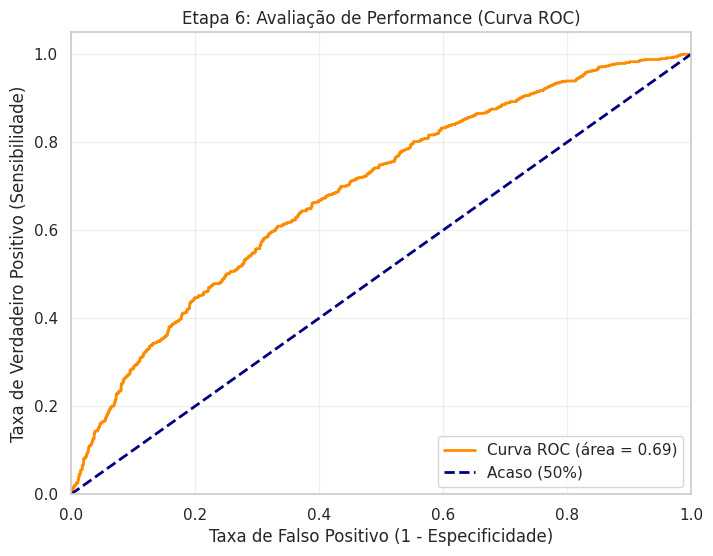

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Acaso (50%)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiro Positivo (Sensibilidade)')
plt.title('Etapa 6: Avaliação de Performance (Curva ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Capacidade de Discriminação: A "barriga" da curva laranja em relação à linha pontilhada azul mostra que o modelo aprendeu a distinguir doentes de saudáveis. Como a área (AUC) é de aproximadamente 0.69, o modelo é considerado útil para triagem.

Sensibilidade vs. Falsos Positivos: O gráfico permite escolher o melhor ponto de corte. Se movermos para a direita na curva, aumentamos a detecção de doentes (Sensibilidade), mas o custo é aumentar o número de pessoas saudáveis que o modelo dirá estarem doentes (Falsos Positivos).

Validação de Negócio: Um AUC próximo de 0.70 em saúde cardíaca indica que o modelo é um excelente primeiro filtro para enfermeiros ou médicos decidirem quem deve realizar exames mais caros (como um ecocardiograma).

# 7) Explique:

A) Explique com suas palavras regressão logistica.

É um algoritmo que calcula a probabilidade de um evento ocorrer (ex: ter ou não doença). Ele transforma uma combinação de fatores (peso, idade) em um valor entre 0 e 1, decidindo o resultado com base em uma curva em formato de "S" (sigmoide).


B) Explique porque a regressão logistica é um modelo de classificação.

Porque, apesar de calcular números no meio do processo, o objetivo final é separar em categorias. No nosso caso, o modelo "carimba" o paciente como Classe 0 (Saudável) ou Classe 1 (Doente).

C) Explique quais pontos em comum a regressão logistica tem da regressão linear.

A Base: Ambas usam a mesma fórmula matemática linear ($y = ax + b$) para começar o cálculo.Os Pesos: Ambas atribuem coeficientes (importância) para cada variável (ex: a idade pesa mais que a altura).A Preparação: Ambas exigem dados limpos e bem organizados para funcionarem corretamente.
